In [1]:
import cv2
import numpy as np
import torch
import json
from sam2.sam2_image_predictor import SAM2ImagePredictor
from transformers import CLIPProcessor, CLIPModel
from sentence_transformers import SentenceTransformer
import chromadb
import google.generativeai as genai
import os
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from dotenv import load_dotenv
load_dotenv()

True

In [22]:
# --- Carga de API keys desde .env ---
genai.configure(api_key=os.getenv('GEMINI_API_KEY'))

# --- Configuración de dispositivos ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Modelo para segmentación y caption ---
predictor = SAM2ImagePredictor.from_pretrained(
    "facebook/sam2-hiera-large",
    device="cpu"
)

# --- Modelos para RAG+CLIP ---
# CLIP para embeddings de crop
clip_model     = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
# MiniLM para embeddings de texto
model_text     = SentenceTransformer(
    "sentence-transformers/all-MiniLM-L6-v2",
    device=device
)

# --- Cliente y colecciones Chroma ---
client    = chromadb.PersistentClient(path="C:/Users/weiha/Documents/HackUPC_2025/Wei/chroma_db")
text_col  = client.get_or_create_collection(
    name="tavascan_text",
    metadata={"hnsw:space": "cosine"}
)
img_col   = client.get_or_create_collection(
    name="tavascan_images",
    metadata={"hnsw:space": "cosine"}
)

# --- Lectura de imagen ---
img_bgr = cv2.imread("C:/Users/weiha/Documents/HackUPC_2025/img/dashboard.jpeg")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
predictor.set_image(img_rgb)

In [18]:
# Variables globales
ref_pt = []           # puntos de la selección (en coords de display)
drawing = False       # flag de arrastre
scale_percent = 100   # zoom inicial en porcentaje
img = img_bgr.copy()  # imagen original
h_orig, w_orig = img.shape[:2]

# Función para recalcular la imagen mostrada según el zoom
def update_display():
    global img_display, img_copy, scale
    scale = scale_percent / 100.0
    w_disp = int(w_orig * scale)
    h_disp = int(h_orig * scale)
    img_display = cv2.resize(img, (w_disp, h_disp), interpolation=cv2.INTER_AREA)
    img_copy = img_display.copy()
    # Si ya hay ref_pt, redibuja el rectángulo en img_copy
    if len(ref_pt) == 2:
        cv2.rectangle(img_copy, ref_pt[0], ref_pt[1], (0, 255, 0), 2)

# Callback para el trackbar de zoom
def on_trackbar(val):
    global scale_percent
    scale_percent = max(val, 1)  # evita 0%
    update_display()

# Callback para el mouse: dibuja y captura la caja en coords de display
def mouse_callback(event, x, y, flags, param):
    global ref_pt, drawing, img_copy
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ref_pt = [(x, y)]
    elif event == cv2.EVENT_MOUSEMOVE and drawing:
        img_copy = img_display.copy()
        cv2.rectangle(img_copy, ref_pt[0], (x, y), (0, 255, 0), 2)
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        ref_pt.append((x, y))
        img_copy = img_display.copy()
        cv2.rectangle(img_copy, ref_pt[0], ref_pt[1], (0, 255, 0), 2)
        # Mapea coords de display a coords originales
        x0_disp, y0_disp = ref_pt[0]
        x1_disp, y1_disp = ref_pt[1]
        x0 = int(x0_disp / scale)
        y0 = int(y0_disp / scale)
        x1 = int(x1_disp / scale)
        y1 = int(y1_disp / scale)
        print(f"Coordenadas en imagen original: ({x0},{y0}) → ({x1},{y1})")

# Prepara la ventana y los callbacks
update_display()
cv2.namedWindow("Selector de caja")
cv2.createTrackbar("Zoom %", "Selector de caja", scale_percent, 300, on_trackbar)
cv2.setMouseCallback("Selector de caja", mouse_callback)

# Bucle de visualización
while True:
    cv2.imshow("Selector de caja", img_copy)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("r"):       # 'r' resetea la selección
        ref_pt = []
        img_copy = img_display.copy()
    elif key == ord("q"):     # 'q' sale
        break

cv2.destroyAllWindows()

Coordenadas en imagen original: (223,174) → (-16,3)


In [19]:
# tras el bucle y antes de usar predictor:
x0_disp, y0_disp = ref_pt[0]
x1_disp, y1_disp = ref_pt[1]

# Asegura que (x0_disp,y0_disp) sea la esquina superior-izquierda
x0_disp, x1_disp = sorted([x0_disp, x1_disp])
y0_disp, y1_disp = sorted([y0_disp, y1_disp])

# Mapea a coordenadas de la imagen original y clampa
x0 = int(x0_disp / scale)
y0 = int(y0_disp / scale)
x1 = int(x1_disp / scale)
y1 = int(y1_disp / scale)

# Evita salirse de los límites
x0 = max(0, min(x0, w_orig - 1))
y0 = max(0, min(y0, h_orig - 1))
x1 = max(1, min(x1, w_orig    ))
y1 = max(1, min(y1, h_orig    ))

# ------------------------------------------------------------------------

# boxleft = 492
# boxtop = 116
# boxwidth = 150
# boxheight = 69

# x0 = boxleft
# y0 = boxtop
# x1 = boxleft + boxwidth
# y1 = boxtop + boxheight

box = np.array([[x0, y0, x1, y1]], dtype=np.int32)

with torch.inference_mode():
    masks, scores, logits = predictor.predict(
        box=box,
        multimask_output=False,
        return_logits=True
    )

mask = masks[0]
crop = img_rgb[y0:y1, x0:x1]

# convierte de RGB a BGR para cv2
crop_bgr = cv2.cvtColor(crop, cv2.COLOR_RGB2BGR)
cv2.imshow("Region seleccionada", crop_bgr)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [20]:
# --- RAG con descripción textual como puente (VERSIÓN CORREGIDA) ---
# 1) Generate image description with Gemini
model = genai.GenerativeModel('gemini-2.0-flash-001')
crop_pil = Image.fromarray(crop)

# Request a detailed description of the selected region
description_prompt = "Describe briefly and technically what component of the CUPRA Tavascan dashboard is shown in this image. Be specific and use technical terms."
description_response = model.generate_content([description_prompt, crop_pil])
image_description = description_response.text.strip()  # <-- CORRECTED

print(f"Generated description: {image_description}")

# 2) Generate text embedding from the description
text_embedding = model_text.encode([image_description], normalize_embeddings=True)[0]

# 3) Query collections using text embedding
txt_hits = text_col.query(
    query_embeddings=[text_embedding.tolist()],
    n_results=4,
    include=["documents", "metadatas", "distances"]
)

# 4) Extract keywords to enrich the context
keywords_prompt = "Extract 3-5 technical key terms from this text that appear in the official CUPRA Tavascan manual: " + image_description
keywords_response = model.generate_content(keywords_prompt)
keywords = keywords_response.text.strip()  # <-- CORRECTED

print(f"Extracted keywords: {keywords}")

# 5) Build context with retrieved information
if txt_hits["documents"] and len(txt_hits["documents"][0]) > 0:
    context_txt = "\n".join(
        f"- {doc} (p.{meta.get('start_page', 'N/A')}, relevance: {score:.2f})"
        for doc, meta, score in zip(txt_hits["documents"][0], txt_hits["metadatas"][0], txt_hits["distances"][0])
    )
else:
    context_txt = "No relevant fragments found in the manual."

# 6) Complete RAG prompt
prompt = (
    f"You are an expert on the CUPRA Tavascan owner's manual.\n\n"
    f"The image shows: {image_description}\n\n"
    f"Key terms: {keywords}\n\n"
    f"Relevant information from the manual:\n{context_txt}\n\n"
    f"Based on this information and what you observe in the image, explain in detail "
    f"what component of the CUPRA Tavascan dashboard is shown, what it is used for, "
    f"and how it should be used. Use only official terminology that appears in the manual."
)

# 7) Create multimodal query with text and image
response = model.generate_content([prompt, crop_pil])
print("\nEnhanced RAG response:\n", response.text)

Generated description: Based on the image, the component shown is the **housing and lens of the Digital Rear-View Mirror (DRVM) system.**  It's likely incorporating an **LCD panel** displaying a video feed from a rear-mounted camera, providing an unobstructed view behind the vehicle. The housing likely includes a surround designed to minimize glare and reflections on the LCD screen.
Extracted keywords: Here are 3 key technical terms extracted from the text:

1.  **Digital Rear-View Mirror (DRVM)**: This is the primary system being described and a key feature of the vehicle.
2.  **LCD panel**: Specifies the type of display technology used in the DRVM.
3.  **Video Feed**: References the source of the image displayed on the LCD panel, which is a critical part of how the DRVM functions.

Enhanced RAG response:
 Based on the image and the provided information from the CUPRA Tavascan owner's manual, the component shown is part of the **Digital Rear-View Mirror (DRVM)** system. While the manu

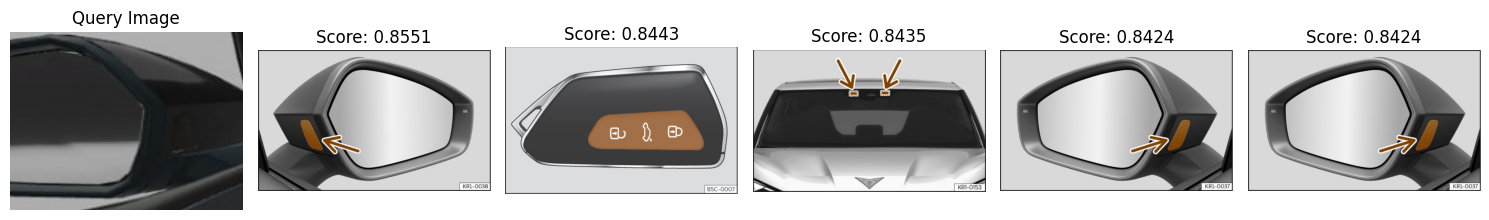


Imágenes más similares del manual:
1. page_196_img_2.jpeg: 0.8551
2. page_93_img_1.png: 0.8443
3. page_139_img_2.jpeg: 0.8435
4. page_196_img_1.jpeg: 0.8424
5. page_227_img_2.jpeg: 0.8424


In [21]:
# --- Ranking de imágenes por similitud visual ---
# Directorio de imágenes del manual
images_folder = "C:/Users/weiha/Documents/HackUPC_2025/extracted_content_manual/images"

def rank_similar_images(input_image, top_k=5):
    """Rank manual images by similarity to input image"""
    # Si input_image es un array (ej: crop), convertir a PIL Image
    if isinstance(input_image, np.ndarray):
        input_pil = Image.fromarray(input_image)
        # Guardar temporalmente
        temp_path = "temp_query_image.jpg"
        input_pil.save(temp_path)
        query_path = temp_path
    else:
        # Si ya es una ruta
        query_path = input_image

    # Obtener embedding de la imagen query con el mismo modelo CLIP ya cargado
    inputs_query = clip_processor(images=Image.open(query_path).convert("RGB"), return_tensors="pt").to(device)
    with torch.no_grad():
        query_emb = clip_model.get_image_features(**inputs_query)
        query_emb = query_emb / query_emb.norm(p=2, dim=-1, keepdim=True)
    query_emb = query_emb.cpu().numpy()[0]

    # Procesar todas las imágenes en el directorio
    similarities = []
    image_paths = list(Path(images_folder).glob("*.jpeg")) + list(Path(images_folder).glob("*.jpg")) + list(Path(images_folder).glob("*.png"))

    for img_path in image_paths:
        try:
            img = Image.open(img_path).convert("RGB")
            inputs = clip_processor(images=img, return_tensors="pt").to(device)
            with torch.no_grad():
                img_emb = clip_model.get_image_features(**inputs)
                img_emb = img_emb / img_emb.norm(p=2, dim=-1, keepdim=True)
            img_emb = img_emb.cpu().numpy()[0]

            # Calcular similitud
            similarity = np.dot(query_emb, img_emb)
            similarities.append((str(img_path), similarity, img))
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    # Ordenar por similitud (descendente)
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Visualizar resultados
    n_images = min(top_k + 1, len(similarities) + 1)

    # Manejo especial si no hay suficientes imágenes
    if n_images <= 1:
        fig, ax = plt.subplots(figsize=(5, 5))
        if isinstance(input_image, np.ndarray):
            ax.imshow(cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR))
        else:
            ax.imshow(Image.open(query_path))
        ax.set_title("Query Image")
        ax.axis('off')
    else:
        fig, axes = plt.subplots(1, n_images, figsize=(15, 4))

        # Asegúrate de que axes es siempre una lista
        if n_images == 2:  # Solo 2 imágenes (query + 1 similar)
            axes = [axes[0], axes[1]]

        # Imagen query
        if isinstance(input_image, np.ndarray):
            axes[0].imshow(input_image)  # Ya está en RGB si viene de img_rgb
        else:
            axes[0].imshow(Image.open(query_path))
        axes[0].set_title("Query Image")
        axes[0].axis('off')

        # Imágenes similares
        for i in range(min(top_k, len(similarities))):
            path, score, img = similarities[i]
            axes[i+1].imshow(img)
            axes[i+1].set_title(f"Score: {score:.4f}")
            axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

    # Limpiar archivo temporal si fue creado
    if isinstance(input_image, np.ndarray) and os.path.exists(temp_path):
        os.remove(temp_path)

    # Devolver los resultados
    return [(path, score) for path, score, _ in similarities[:top_k]]

# Usar la función con la región recortada
similar_images = rank_similar_images(crop, top_k=5)
print("\nImágenes más similares del manual:")
for i, (path, score) in enumerate(similar_images, 1):
    print(f"{i}. {os.path.basename(path)}: {score:.4f}")